In [243]:
import cv2 as cv
import numpy as np
try:
  import wget
except:
  !pip install wget
  import wget
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [244]:
url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimg.freepik.com%2Fpremium-photo%2Fhand-reaching-up-sun-with-sun-shining-through-fingers_593294-11055.jpg&f=1&nofb=1&ipt=1e524bbe102cde52453fc3407e94b12d836dcd2aa9c2ea175965c65a24b7ddc5"
filename = wget.download(url)
print(os.path.abspath(filename))

/content/hand-reaching-up-sun-with-sun-shining-through-fingers_593294-11055-1816316661 (4).jpg


In [245]:
import tqdm
tqdm.__version__

'4.67.1'

In [246]:
t = 0
colors = cv.imread(filename)

colors = cv.cvtColor(colors, cv.COLOR_BGR2LAB)
L, A, B = cv.split(colors)

def calculate_img(B, t, name):
  import tqdm
  mask = []
  distance = []
  for x in tqdm.tqdm(range(B.shape[0]), desc=f"{name}: X",leave=False):
    for y in range(B.shape[1]):
      if (B.max() > B[x,y] + t):
          dist = B.max() - B[x,y] + t
          distance.append(dist)
          mask.append(True)
      else:
          mask.append(False)
  return mask, distance

mask,distance = calculate_img(B, t,"precompute")
premask = np.array(mask, dtype=bool)
mask = premask.reshape(B.shape[0], B.shape[1])

distance_np = np.array(distance,dtype=np.float32)
print(np.mean(distance_np), np.std(distance_np))
distance_scalar = np.mean(distance_np)

32.281487 7.6543903


(417, 626) (417, 626) (417, 626)
uint8 uint8 uint8


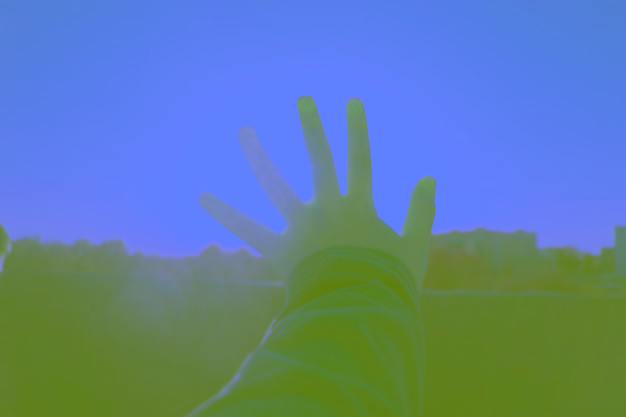

In [247]:
B_new = (B - distance_scalar)
B_new = B_new.astype(np.uint8)
print(B_new.shape, A.shape, L.shape)
print(B_new.dtype, A.dtype, L.dtype)
LAB_new = cv.merge([L, A, B_new])
cv2_imshow(LAB_new)

In [248]:
file = wget.download("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fstatic.vecteezy.com%2Fsystem%2Fresources%2Fpreviews%2F005%2F857%2F332%2Fnon_2x%2Ffunny-portrait-of-cute-corgi-dog-outdoors-free-photo.jpg&f=1&nofb=1&ipt=ff8b0f93ec16c1ab386a360c3ba913b8df4a4f97df5aa26da15c431fcd961aee")
print(file)
corgis_LAB = cv.imread(file)
corgis_LAB = cv.cvtColor(corgis_LAB, cv.COLOR_BGR2LAB)
corgis_L, corgis_A, corgis_B = cv.split(corgis_LAB)

funny-portrait-of-cute-corgi-dog-outdoors-free-photo-2353535905 (2).jpg


255


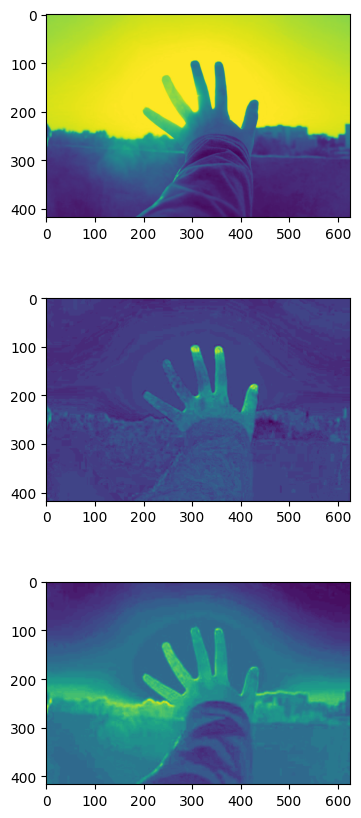

In [249]:
fig = plt.figure(figsize=(10,10))
gs = plt.GridSpec(3,1,height_ratios=[1,1,1], hspace=0.4)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])

ax0.imshow(L, cmap='viridis')
ax1.imshow(A, cmap='viridis')
ax2.imshow(B_new, cmap='viridis')
print(L.max())  #[1,100] rozsah 255
plt.show()

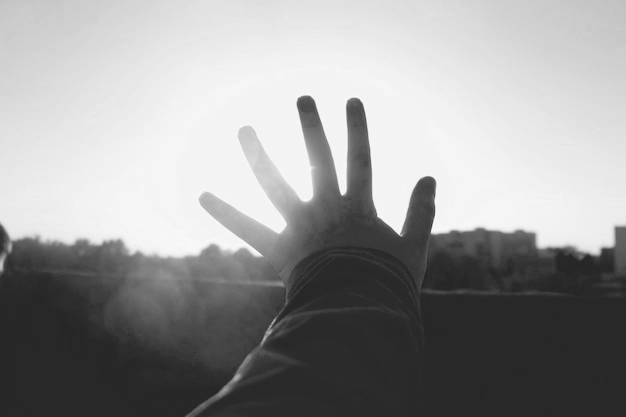

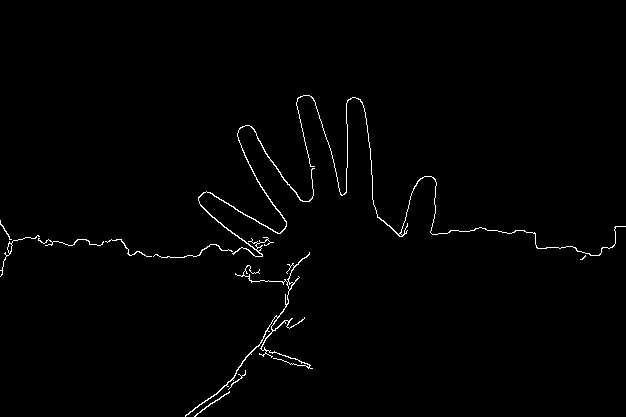

In [250]:
L_cliped = np.clip(L, 50, 255)
L_cliped = L_cliped.astype(np.uint8)

clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
L_clahe = clahe.apply(L_cliped)

L_m = L.max()
A_scaled = (A * L_m).clip(0,255).astype(np.uint8)
LAB_CLP = cv.merge([L_cliped, A_scaled, B_new])

LAB_BGR = cv.cvtColor(LAB_CLP, cv.COLOR_LAB2BGR)
grayscale = cv.cvtColor(LAB_BGR, cv.COLOR_BGR2GRAY)
edges = cv.Canny(grayscale, 0, 255)
cv2_imshow(grayscale)
cv2_imshow(edges)

In [254]:
#sobel: (l) luminance, pocitame s respektem k ose (x,y)
sobel_x = cv.Sobel(edges, cv.CV_64F, 1,0,ksize=3)
sobel_y = cv.Sobel(edges, cv.CV_64F, 0,1,ksize=3)
sobelx8 = cv.convertScaleAbs(sobel_x)
sobely8 = cv.convertScaleAbs(sobel_y)
mag = cv.convertScaleAbs(cv.magnitude(sobel_x, sobel_y))
sobel_rgb = cv.merge((sobelx8, sobely8, mag))
#cv2_imshow(sobel_rgb)

#laplacian obrazku (druha derivace s respektem k (x,y))
laplacian_img=cv.Laplacian(sobel_rgb, cv.CV_64F)

In [255]:
ycrcb = cv.cvtColor(grayscale, cv.COLOR_BGR2YCrCb)
y, _, _ = cv.split(ycrcb)
cv2_imshow(y)

error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-15:Bad number of channels) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


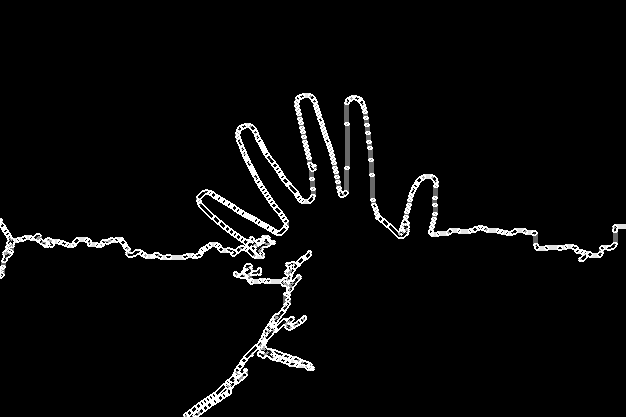

In [256]:
converted_laplacian = cv.convertScaleAbs(laplacian_img)
laplacian_gray = cv.cvtColor(converted_laplacian, cv.COLOR_BGR2GRAY)

cv2_imshow(laplacian_gray)

In [257]:
from scipy import ndimage

_, maska = cv.threshold(laplacian_gray, 1, 240, cv.THRESH_BINARY)
mask = maska.astype(np.bool)

labeled_mask, num_labels = ndimage.label(mask)
#cv2_imshow(labeled_mask)
print(num_labels)

cluster = []
for i in range(1, num_labels + 1):
  label_mask = (labeled_mask == i)
  cluster.append(label_mask)


2


In [258]:
from scipy import ndimage
import numpy as np
import cv2 as cv

# maska = binární maska z thresholdu
_, maska = cv.threshold(laplacian_gray, 1, 240, cv.THRESH_BINARY)
mask = maska.astype(bool)

# Label connected components
labeled_mask, num_labels = ndimage.label(mask)

print("Počet nalezených clusterů:", num_labels)

h, w = mask.shape
total_pixels = h * w

# minimálně 5 % ze všech pixelů
min_pixels = int(total_pixels * 0.1)

print("Minimální velikost clusteru:", min_pixels)

valid_clusters = []

for i in range(1, num_labels + 1):
    label_mask = (labeled_mask == i)
    cluster_size = np.sum(label_mask)

    if cluster_size >= min_pixels:
        valid_clusters.append(label_mask)

print("Počet clusterů po filtrování:", len(valid_clusters))


Počet nalezených clusterů: 2
Minimální velikost clusteru: 26104
Počet clusterů po filtrování: 0


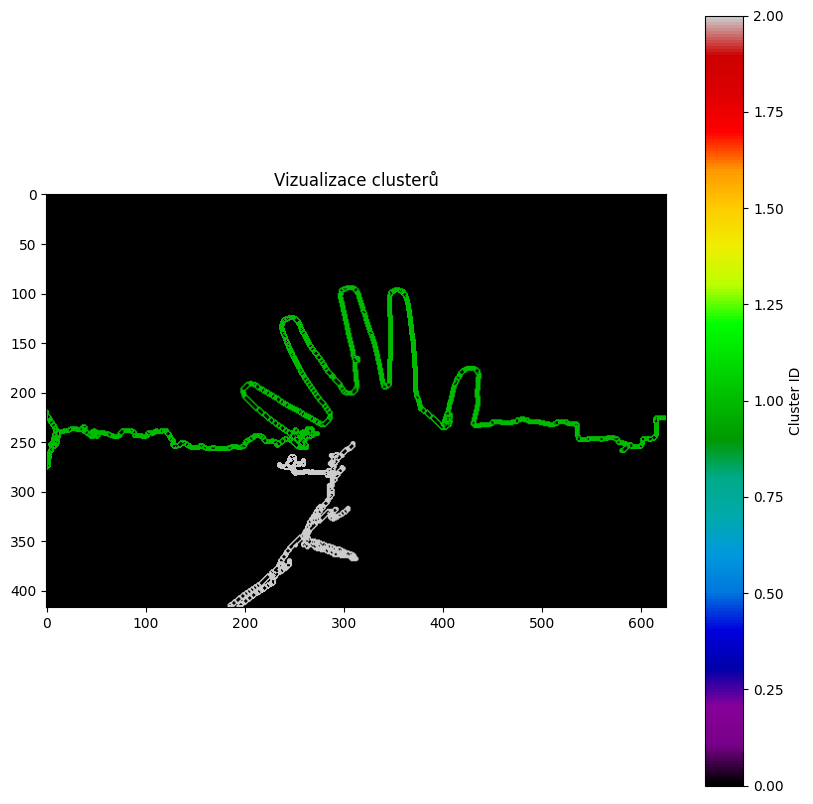

In [259]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,10))
plt.imshow(labeled_mask, cmap='nipy_spectral')
plt.colorbar(label="Cluster ID")
plt.title("Vizualizace clusterů")

for i, label_mask in enumerate(valid_clusters, start=1):
    coords = np.argwhere(label_mask)
    y, x = coords.mean(axis=0)
    plt.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center')

plt.show()

In [260]:
img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

keys = np.array(cluster)
keys.shape, img2.shape

sliced = []
sliced_gray = []
for i,coords in enumerate(keys):
  #print(i, coords)
  sliced.append(img2[coords])
  sliced_gray.append(img2_gray[coords])

np.array(sliced, dtype=object).shape
np.array(sliced_gray, dtype=object).shape

for i in range(len(sliced)):
  print(sliced[i].shape)
  print(f"Cluster {i}: len={len(sliced[i].shape)}, min={sliced[i].min()}, max={sliced[i].max()}, mean={sliced[i].mean():.2f}, std={sliced[i].std():.2f}")

NameError: name 'img2' is not defined

In [261]:
kernel_size = 15
kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)
local_mean = cv.filter2D(img2_gray, -1, kernel)

print(local_mean.shape)
cluster_means = []

for i in range(len(sliced_gray)):
  cluster_means.append(img2_gray[sliced_gray[i]].mean())

diff = [local_mean - cluster_means[i] for i in range(len(sliced_gray))]
diff_with_index = [(local_mean - cluster_means[i], i) for i in range(len(sliced_gray))]

diff = np.array(diff, dtype=object)

NameError: name 'img2_gray' is not defined

In [262]:
plate = np.zeros_like(img2_gray, dtype=np.float32)

for i, cluster_mask in enumerate(sliced_gray):
    plate[cluster_mask] = diff[i][cluster_mask]

NameError: name 'img2_gray' is not defined

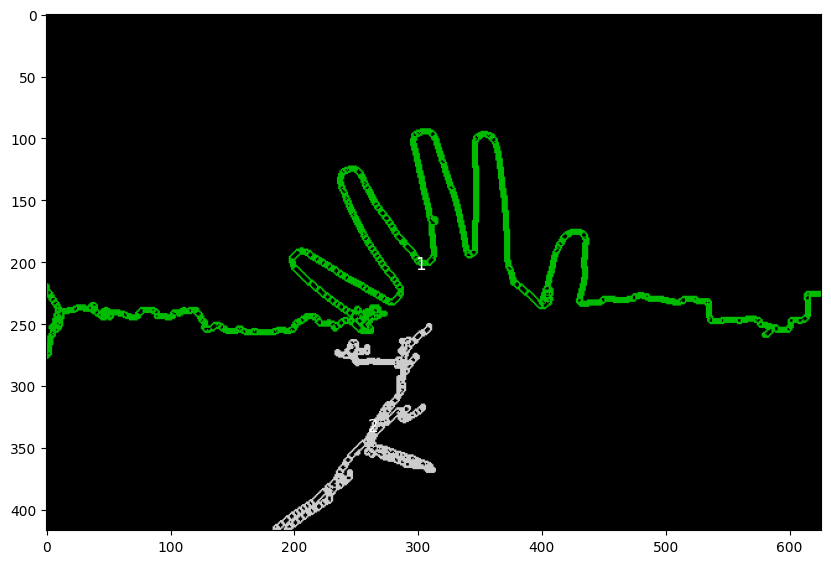

In [263]:
plt.figure(figsize=(10,10))
plt.imshow(labeled_mask, cmap='nipy_spectral')

for i, label_mask in enumerate(cluster, start=1):
    coords = np.argwhere(label_mask)
    y, x = coords.mean(axis=0)
    plt.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center')
plt.show()

NameError: name 'plate' is not defined

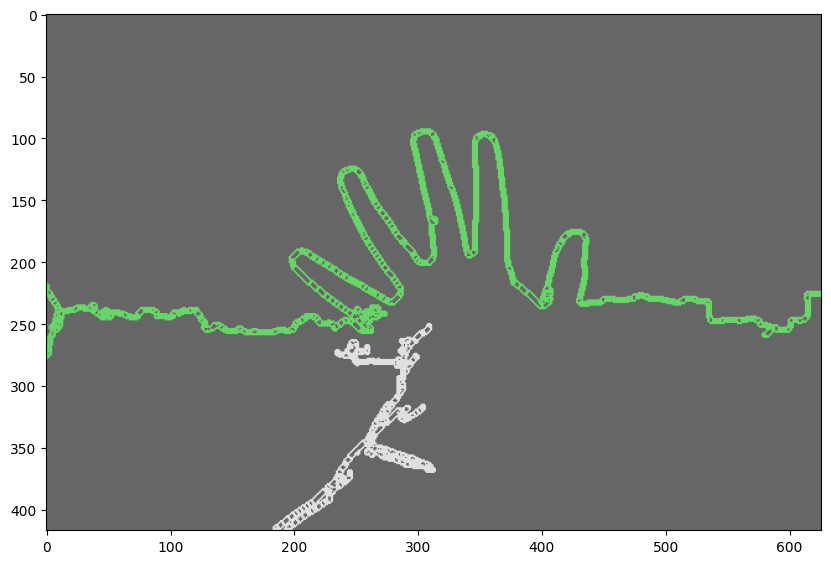

In [264]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))

plt.imshow(labeled_mask, cmap='nipy_spectral', alpha=0.6)

plt.imshow(plate, cmap='bwr', alpha=0.4)

for i, label_mask in enumerate(cluster, start=1):
    coords = np.argwhere(label_mask)
    y, x = coords.mean(axis=0)
    plt.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center')

plt.title("Clusters with plate overlay")
plt.axis('off')
plt.colorbar(label="Contrast / local difference")
plt.show()